# Assignment 03. Classical, ML, and Deep Learning Approaches to Microscopy Analysis

## Task 1. Classical Image Analysis Pipeline

### Part A. Setup and Configuration

In [12]:
# Import libraries
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.color import rgb2gray

# Repro / display niceties
np.random.seed(0)
plt.rcParams["figure.dpi"] = 120

# Paths
RAW_DIR = Path("raw_data") # the local DOPAD folder
OUT_DIR = Path("classical_results") # where the CSV + figures will be saved
OUT_DIR.mkdir(exist_ok=True)

# How many images to process for Task 1 pipeline
N_IMAGES = 100

### Part B. Collect Image Filepaths

In [13]:
exts = ["*.png"]

image_paths = []
for ext in exts:
    image_paths += sorted(RAW_DIR.glob(ext))

if len(image_paths) == 0:
    raise FileNotFoundError(f"No images found in {RAW_DIR.resolve()}")

print("Found images:", len(image_paths))
print("First 5:", [p.name for p in image_paths[:5]])

# Use the defined subset for this assignment task
image_paths = image_paths[:min(N_IMAGES, len(image_paths))]
print("Using images:", len(image_paths))

Found images: 201
First 5: ['11500X00.png', '11500X01.png', '11500X02.png', '11500X03.png', '11500X04.png']
Using images: 100


### Part C. Helper Functions

In [14]:
from typing import Dict, Tuple
from skimage.filters import threshold_otsu, median
from skimage.morphology import disk, remove_small_objects, remove_small_holes
from skimage.filters import gaussian
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import exposure
from scipy import ndimage as ndi
from skimage.measure import regionprops_table

def load_grayscale_float01(path: Path) -> np.ndarray:
    """
    Load an image, convert to grayscale if needed, return float image in [0, 1].
    Handles RGBA/RGB and already-grayscale images.
    """
    img = imread(path)

    # If RGBA/RGB, drop alpha if present and convert to grayscale
    if img.ndim == 3:
        if img.shape[-1] == 4:
            img = img[..., :3]
        img = rgb2gray(img) # returns float in [0,1] for uint inputs

    # Ensure float in [0,1]
    img = img.astype(np.float64, copy=False)
    if img.max() > 1.0:
        img = (img - img.min()) / (img.max() - img.min() + 1e-12)

    return img

def compute_snr_mu_over_sigma(img01: np.ndarray) -> float: 
    """SNR = μ/σ (assignment definition)."""
    mu = float(np.mean(img01))
    sigma = float(np.std(img01))
    return np.inf if sigma == 0 else mu / sigma

def denoise_median(img01: np.ndarray, radius: int = 2) -> np.ndarray:
    """Median filter using a disk footprint."""
    return median(img01, footprint=disk(radius))

def apply_clahe(img01: np.ndarray, clip_limit: float = 0.02) -> np.ndarray:
    """
    CLAHE contrast enhancement (required to show per assignment).
    clip_limit should be in 0.01-0.03 range, but will later be rejected.
    """
    return exposure.equalize_adapthist(img01, clip_limit=clip_limit)

def segment_otsu_watershed_dark_particles(
    img01: np.ndarray,
    min_size: int = 50,
    hole_area: int = 50, 
    dist_smooth_sigma: float = 1.0,
    min_distance: int = 10,
    footprint_size: int = 9,
) -> np.ndarray: 
    """
    Otsu + Watershedfor DARK particles on BRIGHT background.

    Returns: 
        labels. int array where 0=background and 1..N are particle labels
    """

    t = threshold_otsu(img01)
    particles = img01 < t # inversion for dark particles

    # light cleanup for watershed stability (implementation detail)
    particles = remove_small_objects(particles, min_size=min_size)
    particles = remove_small_holes(particles, area_threshold=hole_area)

    # distance transform + slight smoothing to suppress spurious maxima
    dist = ndi.distance_transform_edt(particles)
    dist_s = gaussian(dist, sigma=dist_smooth_sigma, preserve_range=True)

    coords = peak_local_max(
        dist_s,
        labels=particles,
        min_distance=min_distance,
        footprint=np.ones((footprint_size, footprint_size), dtype=bool),
    )

    markers = np.zeros(dist.shape, dtype=int)
    if coords.size > 0: 
        markers[tuple(coords.T)] = np.arange(1, coords.shape[0] + 1)

    labels = watershed(-dist_s, markers, mask=particles)
    return labels

def measure_particles(labels: np.ndarray, intensity_img: np.ndarray) -> pd.DataFrame:
    """
    Measure morphology with regionprops_table.
    intensity_img should match segmentation image (typically denoised).
    """
    props = regionprops_table(
        labels, 
        intensity_image=intensity_img,
        properties=[
            "label",
            "area",
            "equivalent_diameter",
            "eccentricity",
            "solidity",
            "mean_intensity",
        ],
    )
    return pd.DataFrame(props)

In [15]:
# Sanity check on 1 image
test_path = image_paths[0]
img = load_grayscale_float01(test_path)
img_den = denoise_median(img, radius=2)
labels = segment_otsu_watershed_dark_particles(img_den)

print("Loaded:", test_path.name)
print("SNR raw:", compute_snr_mu_over_sigma(img))
print("SNR denoised:", compute_snr_mu_over_sigma(img_den))
print("n particles:", labels.max())

Loaded: 11500X00.png
SNR raw: 4.852891679069054
SNR denoised: 4.863661033112562
n particles: 8


### Part D. Batch Classical Pipeline + CSV export

In [33]:
# Run classical pipeline over subset

all_results = []

for i, path in enumerate(image_paths):
    print(f"Processing {i+1}/{len(image_paths)}: {path.name}")

    # Load
    img = load_grayscale_float01(path)

    # Noise reduction (median)
    img_den = denoise_median(img, radius=3)

    # Compute SNR
    snr_raw = compute_snr_mu_over_sigma(img)
    snr_den = compute_snr_mu_over_sigma(img_den)

    # Segmentation
    labels = segment_otsu_watershed_dark_particles(img_den)

    # Measurements
    df_img = measure_particles(labels, img_den)

    # Add metadata columns
    df_img["image_name"] = path.name
    df_img["snr_raw"] = snr_raw
    df_img["snr_denoised"] = snr_den

    all_results.append(df_img)

# Combine all images
df_all = pd.concat(all_results, ignore_index=True)

print("Total particles detected:", len(df_all))
df_all.head()

Processing 1/100: 11500X00.png
Processing 2/100: 11500X01.png
Processing 3/100: 11500X02.png
Processing 4/100: 11500X03.png
Processing 5/100: 11500X04.png
Processing 6/100: 11500X05.png
Processing 7/100: 11500X06.png
Processing 8/100: 11500X07.png
Processing 9/100: 11500X08.png
Processing 10/100: 11500X09.png
Processing 11/100: 11500X10.png
Processing 12/100: 11500X100.png
Processing 13/100: 11500X101.png
Processing 14/100: 11500X102.png
Processing 15/100: 11500X103.png
Processing 16/100: 11500X104.png
Processing 17/100: 11500X105.png
Processing 18/100: 11500X106.png
Processing 19/100: 11500X107.png
Processing 20/100: 11500X108.png
Processing 21/100: 11500X109.png
Processing 22/100: 11500X11.png
Processing 23/100: 11500X110.png
Processing 24/100: 11500X111.png
Processing 25/100: 11500X112.png
Processing 26/100: 11500X113.png
Processing 27/100: 11500X114.png
Processing 28/100: 11500X115.png
Processing 29/100: 11500X116.png
Processing 30/100: 11500X117.png
Processing 31/100: 11500X118.pn

,label,area,equivalent_diameter,eccentricity,solidity,mean_intensity,image_name,snr_raw,snr_denoised
0,1,6064.0,87.868792,0.464155,0.967454,0.313769,11500X00.png,4.852892,4.886471
1,2,4162.0,72.795762,0.349122,0.957002,0.391954,11500X00.png,4.852892,4.886471
2,3,2313.0,54.267882,0.444351,0.966973,0.469393,11500X00.png,4.852892,4.886471
3,4,1817.0,48.098610,0.144159,0.951309,0.495969,11500X00.png,4.852892,4.886471
4,5,1757.0,47.297800,0.412066,0.960109,0.528472,11500X00.png,4.852892,4.886471


In [34]:
# Export combined CSV
csv_path = OUT_DIR / "classical_results.csv"
df_all.to_csv(csv_path, index=False)

print("Saved to:", csv_path.resolve())

Saved to: C:\Users\elise\OneDrive\Desktop\MATSCI465_EliseEtrheim\assignments\assignment 04\classical_results\classical_results.csv


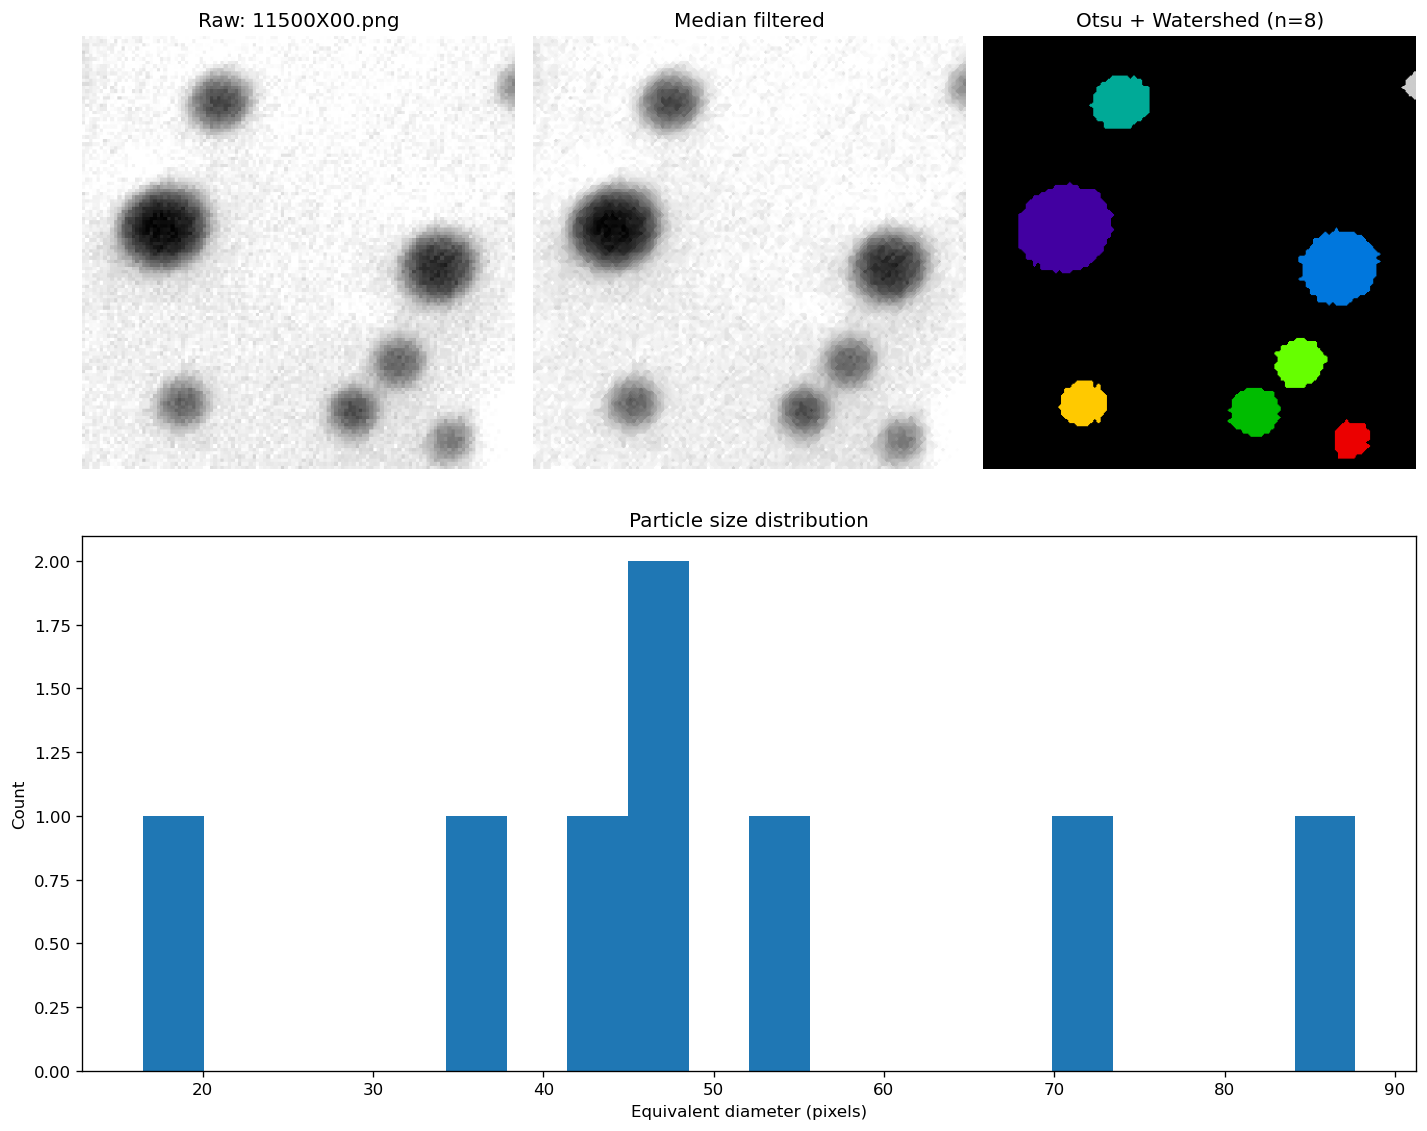

Saved figure to: C:\Users\elise\OneDrive\Desktop\MATSCI465_EliseEtrheim\assignments\assignment 04\classical_results\task1_figure.png


In [35]:
# === Task 1 figure: 3 images on top, histogram spanning bottom ===
import matplotlib.pyplot as plt

rep_path = image_paths[0]  # choose any representative image
img = load_grayscale_float01(rep_path)
img_den = denoise_median(img, radius=2)
labels = segment_otsu_watershed_dark_particles(img_den)
df_rep = measure_particles(labels, img_den)

fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 0.9])

ax_raw = fig.add_subplot(gs[0, 0])
ax_den = fig.add_subplot(gs[0, 1])
ax_lab = fig.add_subplot(gs[0, 2])
ax_hist = fig.add_subplot(gs[1, :])  # span all columns

# Top row
ax_raw.imshow(img, cmap="gray")
ax_raw.set_title(f"Raw: {rep_path.name}")
ax_raw.axis("off")

ax_den.imshow(img_den, cmap="gray")
ax_den.set_title("Median filtered")
ax_den.axis("off")

ax_lab.imshow(labels, cmap="nipy_spectral")
ax_lab.set_title(f"Otsu + Watershed (n={labels.max()})")
ax_lab.axis("off")

# Bottom histogram
ax_hist.hist(df_rep["equivalent_diameter"], bins=20)
ax_hist.set_title("Particle size distribution")
ax_hist.set_xlabel("Equivalent diameter (pixels)")
ax_hist.set_ylabel("Count")

plt.tight_layout()

fig_path = OUT_DIR / "task1_figure.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved figure to:", fig_path.resolve())

In [36]:
# CLAHE note (Task 1 requires showing it)
# In our DOPAD subset, CLAHE (clip_limit=0.02) increased background speckle and reduced
# boundary clarity after Otsu thresholding, so we proceeded with the median-filtered image
# for segmentation.

### Part E. Additional Information for README.md Contribution

In [37]:
# One row per image
snr_summary = (
    df_all
    .groupby("image_name")[["snr_raw", "snr_denoised"]]
    .first()
    .reset_index()
)

# Compute delta
snr_summary["delta_snr"] = (
    snr_summary["snr_denoised"] - snr_summary["snr_raw"]
)

snr_summary.head()

,image_name,snr_raw,snr_denoised,delta_snr
0,11500X00.png,4.852892,4.886471,0.033580
1,11500X01.png,4.852892,4.886471,0.033580
2,11500X02.png,4.101608,4.150693,0.049084
3,11500X03.png,4.101608,4.150693,0.049084
4,11500X04.png,5.162778,5.232652,0.069874


In [38]:
mean_delta = snr_summary["delta_snr"].mean()
median_delta = snr_summary["delta_snr"].median()

print("Mean ΔSNR:", mean_delta)
print("Median ΔSNR:", median_delta)

Mean ΔSNR: 0.07549075529636898
Median ΔSNR: 0.06634706772260124


In [39]:
snr_stats = pd.DataFrame({
    "mean_snr_raw": [snr_summary["snr_raw"].mean()],
    "mean_snr_denoised": [snr_summary["snr_denoised"].mean()],
    "mean_delta_snr": [mean_delta],
    "median_delta_snr": [median_delta],
})

snr_stats

snr_stats.to_csv(OUT_DIR / "snr_summary.csv", index=False)
snr_stats_path = OUT_DIR / "snr_summary.csv"

print("Saved summary table to:", snr_stats_path.resolve())

Saved summary table to: C:\Users\elise\OneDrive\Desktop\MATSCI465_EliseEtrheim\assignments\assignment 04\classical_results\snr_summary.csv
